In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
from scipy.integrate import quad
from scipy.interpolate import interp1d
import numpy as np
from ifs_noise_model import *
import misc_utils as misc_u
from os import system
import simulate_data as simdata

/Users/blacy/EGPSemesterProject/direct-imaging-sims/WFIRST_SIM/misc_utils.py:159: RuntimeWarning: divide by zero encountered in true_divide
  tau_PSF = interp1d(rlamD,coreThruput/occTrans,fill_value=0.0,bounds_error=False)


As described in section 2, the A models have cloud cover extending all the way to the top of the atmosphere, whereas the E models cut off sharply at altitude. The AE and AEE models are intermediate between A and E models, with the AEE models lean- ing more towards the E models for the same Teff and g. All the models have equilibrium chemistry with so- lar abundances. The model nomenclature encapsulates the cloud type and atmospheric parameters. For exam- ple, ‘E60.1000.1s.g4.0’ implies ‘E’ type cloud cover with 60-μm modal particle size, Teff = 1000 K, 1× solar metal- licity, and log10 g = 4.0, where g is in cm s−2

In [2]:
def sl_planet_photon_flux(wavelength, params):
    # input wavelength unit: microns 
    # units of flux returned are photons/m^2/second in bins centered at input wavelength
    # with resolving power R specified in params dictionary
    flux = (wavelength*10.0**-6.0)/(params['h']*params['c']) \
           * params['fp_lambda'](wavelength) * wavelength/params['R']\
           * (10.0/params['d_obs'])**2.0   
    return flux

def sl_planet_star_fluxratio(wavelength, params):
    return sl_planet_photon_flux(wavelength,params)/stellar_photon_flux(wavelength,params)

def sl_planet_star_delta_mag(wavelength, params):
    return -2.5*np.log10(sl_planet_star_fluxratio(wavelength,params))

In [5]:
# set up planet-star-coronagraph-telescope dictionary (change this to be one of HR8799 planets )
params = {}                  
params.update({'d_obs':3.216}) # distance to the observer in parsecs
M = 3.73 - 5.0*np.log10(params['d_obs']/10.0) # convert apparent (3.73) to absolute
params.update({'Mstar':M})   # absolute stellar V-band magnitude 
params.update({'Nez':1.0})     # exozodi level
stellartype = 'k0v'              # stellar type
stellar_mass = 0.781               # stellar mass in units of solar mass 
                                 # this is only used in orbit object, not really relevant for SNR calculations
stellar_spec = 'AuxiliaryData/'+stellartype+'.dat' # imports Hubble 
ref_wl, ref_flambda = np.loadtxt(stellar_spec, unpack=True, usecols=(0,1))
fstar_lambda = interp1d(ref_wl,ref_flambda)  # specific flux density W / m^2 / micron, for zero mag star
params.update({'fstar_lambda':fstar_lambda}) # a function which returns 
                                             # specific flux density for any wavelength
params.update({'rp':0.83294})      # planet radius in Jupiter radii
a = 3.4            # semimajor axis (in au)
ecc = 0.071         # eccentricity
inc = 90.0          # inclination (degrees)
ome = 180.0         # longitude of ascending node (degrees)
tp = 2530054 % (7.37*365) # epoch of perihelion passage (julian date) 2530054
argperi = 3.13     # argument of perihelion (degrees)    
orbit_pars = np.array([ecc,inc,ome,tp,a,argperi,
                       stellar_mass,params['rp'],params['d_obs']])
orbit = Orbit(orbit_pars) 
ophase = 0.8 # orbital phase
pfunc = mu.avg_empirical # type of phase function to use
simdata.change_ophase(orbit, params, ophase, pfunc) # updates params['sep'], params['phi'], params['wa']
params.update(mu.cbe_spc_pars)

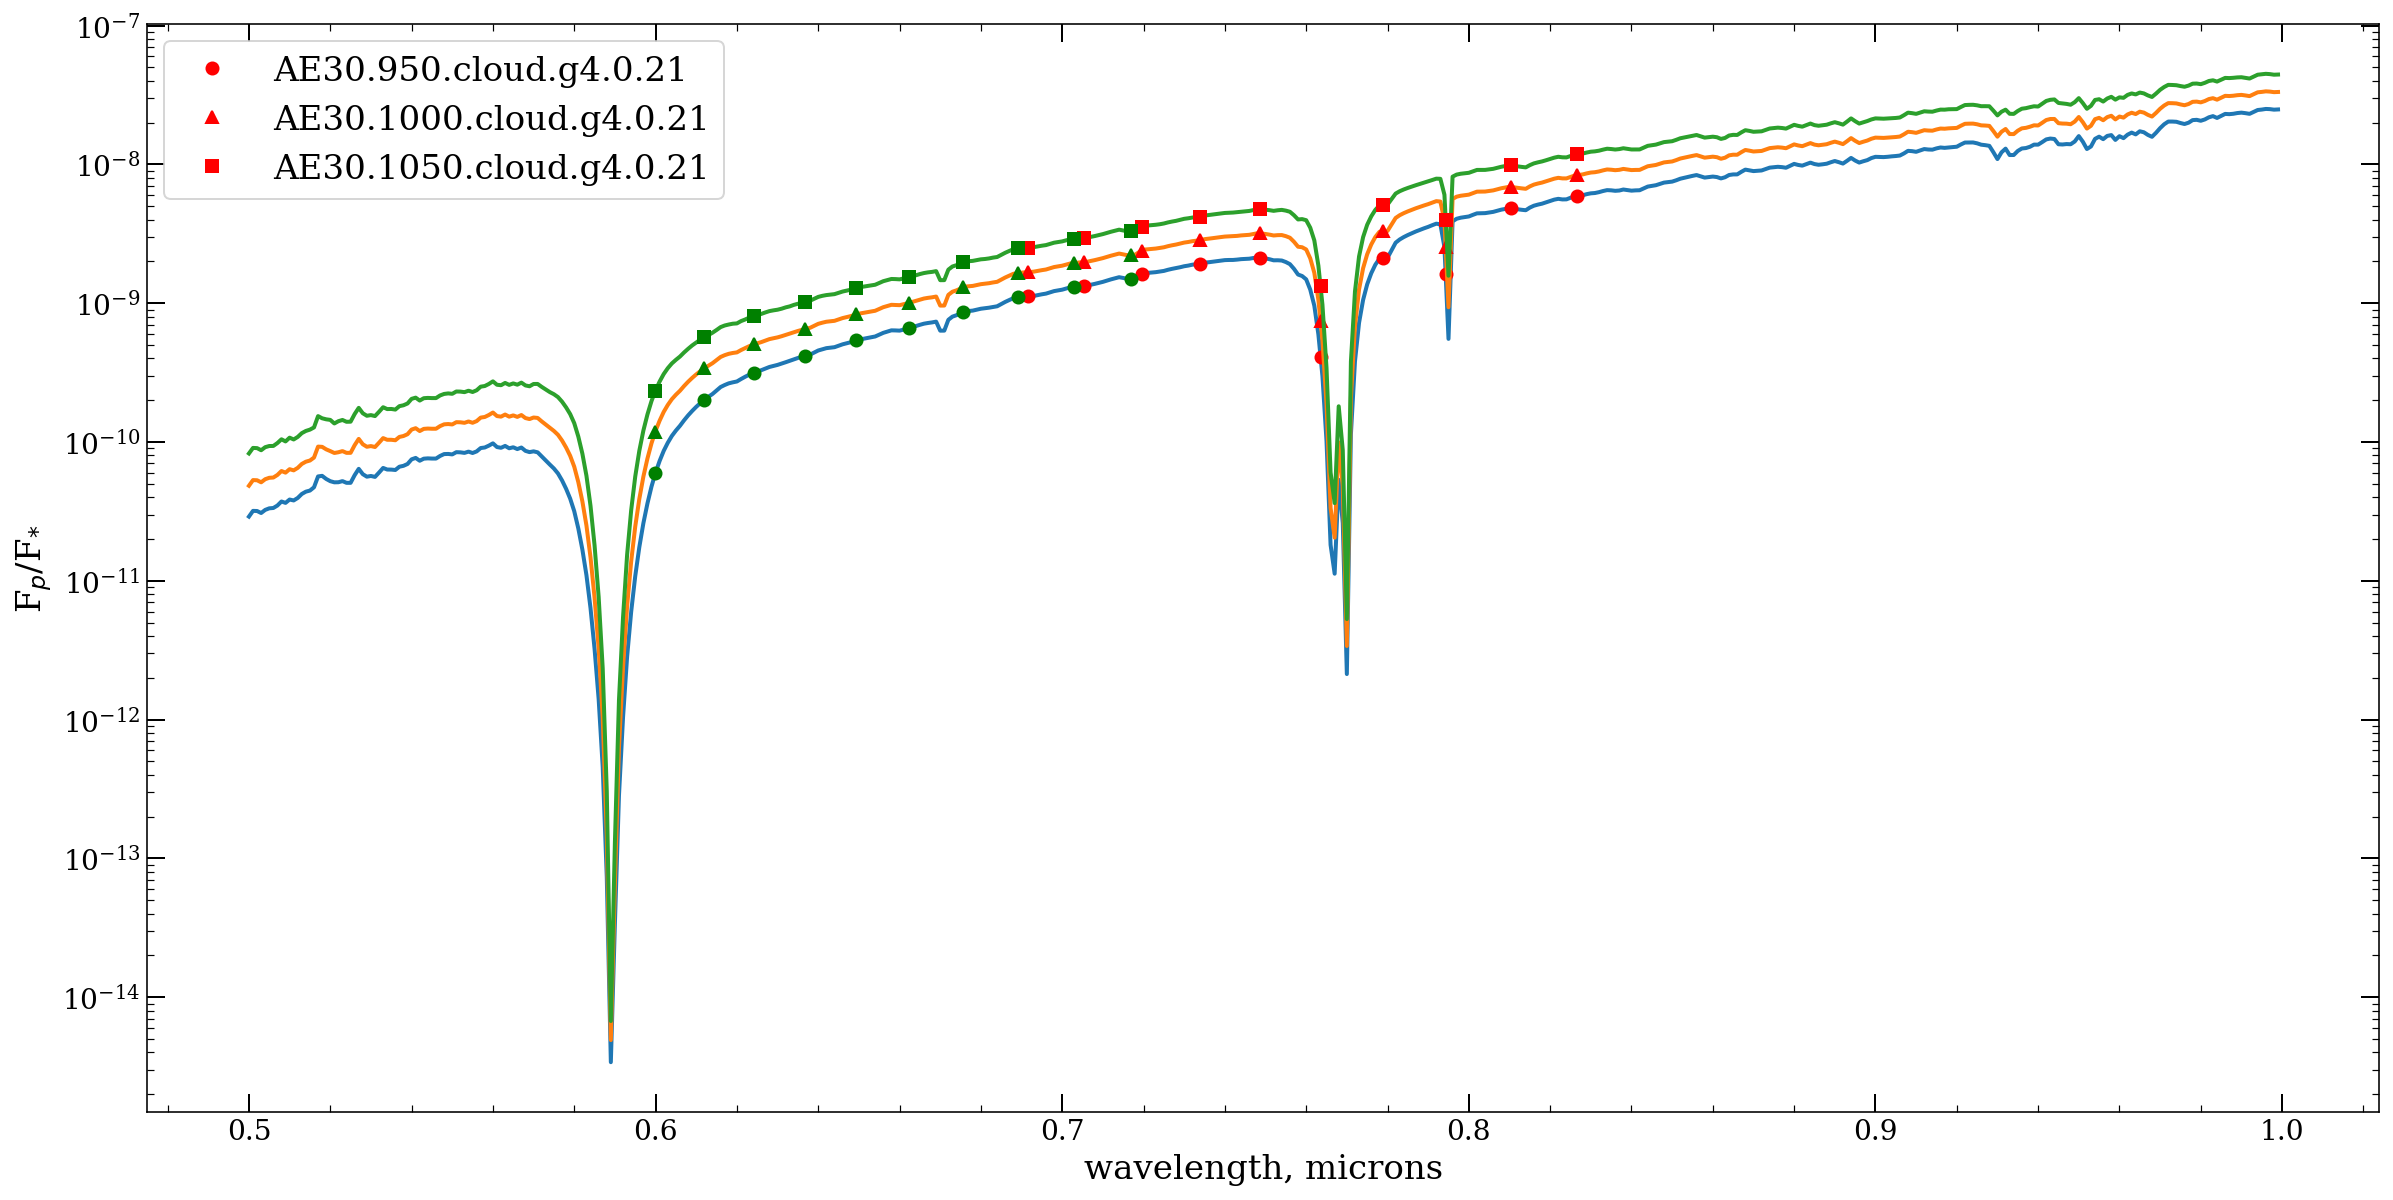

In [11]:
# read in the self-luminous spectra
#    IJ       FREQ       LAMBDA(mic)       FNU         FLAM       
# FDET(milliJ)   LAMBDA(A)       FDETC       TBRIGHT       
# TBRIC         FNUC          PFORM
# FDET = the source is assumed to be at a distance of 10 pc
fname = 'AuxiliaryData/cloud.AE-type/AE30.950.cloud.g4.0.21'
try:
    data = np.loadtxt(fname,skiprows=2,unpack=True)
except:
    system("sed -i '' -e 's/D/E/g' %s"%fname)
    data = np.loadtxt(fname,skiprows=2,unpack=True)
wl = data[2] # microns
fluxdensity = data[5] # milliJy
# need to interpolate fp_lambda 
# and to convert milli Jy to
# W / m^2 / micron
c = 299792458.0
fd_microns = 10.0**-23.0*fluxdensity*c/(wl**2.0)
fp_lambda = interp1d(wl,fd_microns)
params['fp_lambda'] = fp_lambda
wavelengths = np.arange(0.5,1.0,0.001)
bandcenter = 0.76# microns
width = 18.0        # the full width divided by bandcenter * 100.0
IFSband2 = misc_u.create_wl_range(bandcenter*(1.0 - width/200.0), bandcenter*(1.0 + width/200.0),params['R']) 
bandcenter = 0.66# microns
width = 18.2        # the full width divided by bandcenter * 100.0
IFSband1 = misc_u.create_wl_range(bandcenter*(1.0 - width/200.0), bandcenter*(1.0 + width/200.0),params['R']) 
plt.figure(figsize=(20,10))
plt.semilogy(wavelengths,fp_lambda(wavelengths)/fstar_lambda(wavelengths))
plt.semilogy(IFSband2,fp_lambda(IFSband2)/fstar_lambda(IFSband2),'ro',label='AE30.950.cloud.g4.0.21')
plt.semilogy(IFSband1,fp_lambda(IFSband1)/fstar_lambda(IFSband1),'go')
plt.xlabel('wavelength, microns',fontsize=17)
plt.ylabel('F$_{p}$/F$_{*}$',fontsize=17)



fname = 'AuxiliaryData/cloud.AE-type/AE30.1000.cloud.g4.0.21'
try:
    data = np.loadtxt(fname,skiprows=2,unpack=True)
except:
    system("sed -i '' -e 's/D/E/g' %s"%fname)
    data = np.loadtxt(fname,skiprows=2,unpack=True)
wl = data[2] # microns
fluxdensity = data[5] # milliJy
# need to interpolate fp_lambda 
# and to convert milli Jy to
# W / m^2 / micron
c = 299792458.0
fd_microns = 10.0**-23.0*fluxdensity*c/(wl**2.0)
fp_lambda = interp1d(wl,fd_microns)
params['fp_lambda'] = fp_lambda
wavelengths = np.arange(0.5,1.0,0.001)
bandcenter = 0.76# microns
width = 18.0        # the full width divided by bandcenter * 100.0
IFSband2 = misc_u.create_wl_range(bandcenter*(1.0 - width/200.0), bandcenter*(1.0 + width/200.0),params['R']) 
bandcenter = 0.66# microns
width = 18.2        # the full width divided by bandcenter * 100.0
IFSband1 = misc_u.create_wl_range(bandcenter*(1.0 - width/200.0), bandcenter*(1.0 + width/200.0),params['R']) 


plt.semilogy(wavelengths,fp_lambda(wavelengths)/fstar_lambda(wavelengths))
plt.semilogy(IFSband2,fp_lambda(IFSband2)/fstar_lambda(IFSband2),'r^',label='AE30.1000.cloud.g4.0.21')
plt.semilogy(IFSband1,fp_lambda(IFSband1)/fstar_lambda(IFSband1),'g^')




fname = 'AuxiliaryData/cloud.AE-type/AE30.1050.cloud.g4.0.21'
try:
    data = np.loadtxt(fname,skiprows=2,unpack=True)
except:
    system("sed -i '' -e 's/D/E/g' %s"%fname)
    data = np.loadtxt(fname,skiprows=2,unpack=True)
wl = data[2] # microns
fluxdensity = data[5] # milliJy
# need to interpolate fp_lambda 
# and to convert milli Jy to
# W / m^2 / micron
c = 299792458.0
fd_microns = 10.0**-23.0*fluxdensity*c/(wl**2.0)
fp_lambda = interp1d(wl,fd_microns)
params['fp_lambda'] = fp_lambda
wavelengths = np.arange(0.5,1.0,0.001)
bandcenter = 0.76# microns
width = 18.0        # the full width divided by bandcenter * 100.0
IFSband2 = misc_u.create_wl_range(bandcenter*(1.0 - width/200.0), bandcenter*(1.0 + width/200.0),params['R']) 
bandcenter = 0.66# microns
width = 18.2        # the full width divided by bandcenter * 100.0
IFSband1 = misc_u.create_wl_range(bandcenter*(1.0 - width/200.0), bandcenter*(1.0 + width/200.0),params['R']) 


plt.semilogy(wavelengths,fp_lambda(wavelengths)/fstar_lambda(wavelengths))
plt.semilogy(IFSband2,fp_lambda(IFSband2)/fstar_lambda(IFSband2),'rs',label='AE30.1050.cloud.g4.0.21')
plt.semilogy(IFSband1,fp_lambda(IFSband1)/fstar_lambda(IFSband1),'gs')

plt.legend(fontsize=17)

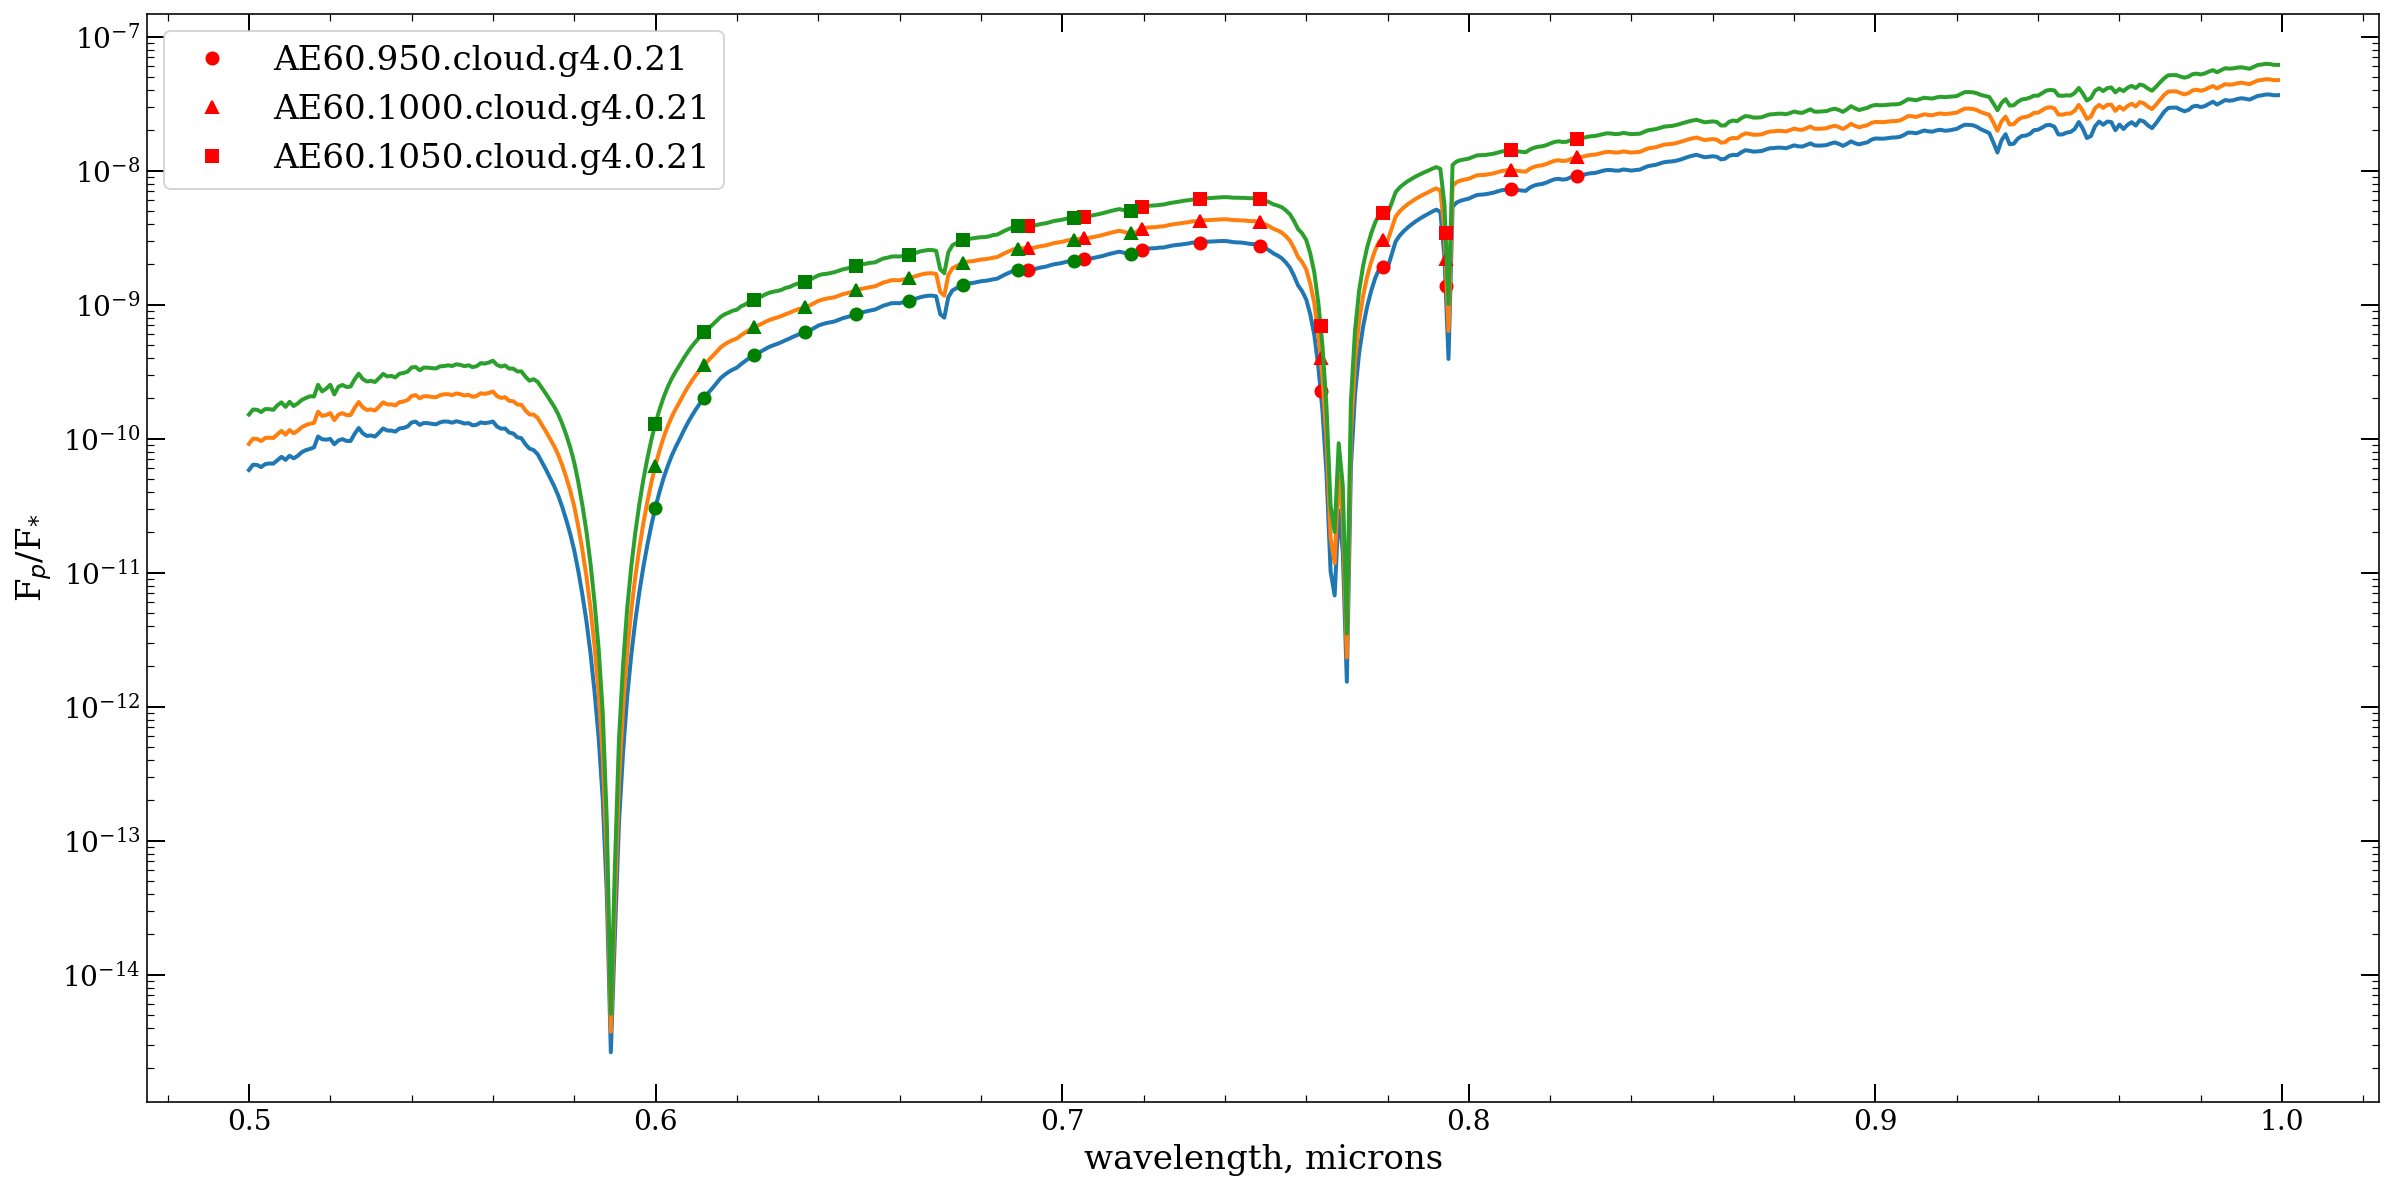

In [12]:
fname = 'AuxiliaryData/cloud.AE-type/AE60.950.cloud.g4.0.21'
try:
    data = np.loadtxt(fname,skiprows=2,unpack=True)
except:
    system("sed -i '' -e 's/D/E/g' %s"%fname)
    data = np.loadtxt(fname,skiprows=2,unpack=True)
wl = data[2] # microns
fluxdensity = data[5] # milliJy
# need to interpolate fp_lambda 
# and to convert milli Jy to
# W / m^2 / micron
c = 299792458.0
fd_microns = 10.0**-23.0*fluxdensity*c/(wl**2.0)
fp_lambda = interp1d(wl,fd_microns)
params['fp_lambda'] = fp_lambda
wavelengths = np.arange(0.5,1.0,0.001)
bandcenter = 0.76# microns
width = 18.0        # the full width divided by bandcenter * 100.0
IFSband2 = misc_u.create_wl_range(bandcenter*(1.0 - width/200.0), bandcenter*(1.0 + width/200.0),params['R']) 
bandcenter = 0.66# microns
width = 18.2        # the full width divided by bandcenter * 100.0
IFSband1 = misc_u.create_wl_range(bandcenter*(1.0 - width/200.0), bandcenter*(1.0 + width/200.0),params['R']) 
plt.figure(figsize=(20,10))
plt.semilogy(wavelengths,fp_lambda(wavelengths)/fstar_lambda(wavelengths))
plt.semilogy(IFSband2,fp_lambda(IFSband2)/fstar_lambda(IFSband2),'ro',label='AE60.950.cloud.g4.0.21')
plt.semilogy(IFSband1,fp_lambda(IFSband1)/fstar_lambda(IFSband1),'go')
plt.xlabel('wavelength, microns',fontsize=17)
plt.ylabel('F$_{p}$/F$_{*}$',fontsize=17)



fname = 'AuxiliaryData/cloud.AE-type/AE60.1000.cloud.g4.0.21'
try:
    data = np.loadtxt(fname,skiprows=2,unpack=True)
except:
    system("sed -i '' -e 's/D/E/g' %s"%fname)
    data = np.loadtxt(fname,skiprows=2,unpack=True)
wl = data[2] # microns
fluxdensity = data[5] # milliJy
# need to interpolate fp_lambda 
# and to convert milli Jy to
# W / m^2 / micron
c = 299792458.0
fd_microns = 10.0**-23.0*fluxdensity*c/(wl**2.0)
fp_lambda = interp1d(wl,fd_microns)
params['fp_lambda'] = fp_lambda
wavelengths = np.arange(0.5,1.0,0.001)
bandcenter = 0.76# microns
width = 18.0        # the full width divided by bandcenter * 100.0
IFSband2 = misc_u.create_wl_range(bandcenter*(1.0 - width/200.0), bandcenter*(1.0 + width/200.0),params['R']) 
bandcenter = 0.66# microns
width = 18.2        # the full width divided by bandcenter * 100.0
IFSband1 = misc_u.create_wl_range(bandcenter*(1.0 - width/200.0), bandcenter*(1.0 + width/200.0),params['R']) 


plt.semilogy(wavelengths,fp_lambda(wavelengths)/fstar_lambda(wavelengths))
plt.semilogy(IFSband2,fp_lambda(IFSband2)/fstar_lambda(IFSband2),'r^',label='AE60.1000.cloud.g4.0.21')
plt.semilogy(IFSband1,fp_lambda(IFSband1)/fstar_lambda(IFSband1),'g^')




fname = 'AuxiliaryData/cloud.AE-type/AE60.1050.cloud.g4.0.21'
try:
    data = np.loadtxt(fname,skiprows=2,unpack=True)
except:
    system("sed -i '' -e 's/D/E/g' %s"%fname)
    data = np.loadtxt(fname,skiprows=2,unpack=True)
wl = data[2] # microns
fluxdensity = data[5] # milliJy
# need to interpolate fp_lambda 
# and to convert milli Jy to
# W / m^2 / micron
c = 299792458.0
fd_microns = 10.0**-23.0*fluxdensity*c/(wl**2.0)
fp_lambda = interp1d(wl,fd_microns)
params['fp_lambda'] = fp_lambda
wavelengths = np.arange(0.5,1.0,0.001)
bandcenter = 0.76# microns
width = 18.0        # the full width divided by bandcenter * 100.0
IFSband2 = misc_u.create_wl_range(bandcenter*(1.0 - width/200.0), bandcenter*(1.0 + width/200.0),params['R']) 
bandcenter = 0.66# microns
width = 18.2        # the full width divided by bandcenter * 100.0
IFSband1 = misc_u.create_wl_range(bandcenter*(1.0 - width/200.0), bandcenter*(1.0 + width/200.0),params['R']) 


plt.semilogy(wavelengths,fp_lambda(wavelengths)/fstar_lambda(wavelengths))
plt.semilogy(IFSband2,fp_lambda(IFSband2)/fstar_lambda(IFSband2),'rs',label='AE60.1050.cloud.g4.0.21')
plt.semilogy(IFSband1,fp_lambda(IFSband1)/fstar_lambda(IFSband1),'gs')

plt.legend(fontsize=17)